# SABBO
Version: 3.0<br>
Contents:<br>
Kaplan-Meier-Curve
Python-Version: 3.11.17


###### tsolve = survivalTime

In [55]:
import csv
import pandas as pd
import math
import matplotlib.pyplot as plt
import re
import numpy as np
from collections import Counter
from scipy.stats import shapiro

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures



In [56]:
# Read CSV
csv_file = 'QUBOClusteringData.csv'

originDf = pd.read_csv(csv_file)

originDf.head()
    

,tsolve,alg,nvars,seed,runseed,Unnamed: 5
0,8.0,UEDA,5,1,1,NaN
1,7.0,GR,5,1,1,NaN
2,13.0,RS,5,1,1,NaN
3,73.0,UEDA,5,1,2,NaN
4,4.0,GR,5,1,2,NaN


#### Functions:

### Topic 1: Kaplan-Meier-Curve
Algorithms end only after unkown time due to unknown issues.
The seed might or might not affect its performance, too. Thus, there are multiple ways in order to retrieve q.

The first Kaplan-Meier-Curves take the different seed into account and assign the last time depending on the seed.<br>
The second Kaplan-Meier-Curves take only the very last time for the number of variables regardless of the seed.

In [57]:
# Make the m-n-q Dataframe 
# @Bool Slots=True: with assignment of each seeds highest runtime for nvars
# @Bool Slots=False: the non-Runtimes retrieve the very highest time for nvars
def makeMNQDf(nvars, alg, slots):
    OrigDf = originDf[(originDf["alg"] == alg) & (originDf["nvars"] == nvars)]
    # Slots:
    if slots:
        maxTSolverPerSeedUEDA = OrigDf[OrigDf["alg"] == alg].groupby("seed")['tsolve'].max().to_dict()

        MNDf = OrigDf[(OrigDf["alg"] == alg) & (OrigDf["nvars"] == nvars)].copy()
        
        for index, row in MNDf.iterrows():
            if pd.isna(row["tsolve"]):
                if pd.isna(maxTSolverPerSeedUEDA[row["seed"]]):
                    maxRuntimeOverall = np.nanmax(list(maxTSolverPerSeedUEDA.values()))
                    MNDf.loc[index, "q SeedZeit"] = maxRuntimeOverall
                else:
                    MNDf.loc[index, "q SeedZeit"] = maxTSolverPerSeedUEDA[row["seed"]]
       
        ArgDf = MNDf.set_index("tsolve").sort_index()

        # make mDict
        allTimes = ArgDf.index.tolist()
        allTimes = [value for value in allTimes if not pd.isna(value)]  # [3.0, 29.0, 31.0, 31.0, 35.0, 45.0, 59.0, 60.0, 65.0, 69.0, 78.0, 81.0, 82.0, 83.0, 85.0, 89.0, 92.0, 96.0, 99.0, 100.0, 102.0, 104.0, 106.0, 107.0, 109.0, 112.0, 115.0, 122.0, 137.0, 144.0, 159.0, 165.0, 168.0, 174.0, 181.0, 212.0, 230.0, 234.0, 235.0, 245.0, 246.0, 258.0, 295.0, 304.0, 313.0, 327.0, 341.0, 343.0, 366.0, 374.0, 375.0, 386.0, 404.0, 415.0, 436.0, 438.0, 474.0, 500.0]

        tmp = Counter(allTimes)
        mDict = dict(tmp)
        mDict[0] = 0
        mDict = dict(sorted(mDict.items(), key=lambda x: x[0]))

    
    # !Slots:
    else:
        ArgDf = OrigDf
        MNDf = OrigDf.copy()
        maxRuntime = max(MNDf["tsolve"])
        MNDf.loc[pd.isna(MNDf["tsolve"]), "q SeedZeit"] = maxRuntime
        MNDf = MNDf.set_index("tsolve").sort_index()

        # make m Dict
        allTimes = MNDf.index.tolist()
        allTimes = [value for value in allTimes if not pd.isna(value)]  # [3.0, 29.0, 31.0, 31.0, 35.0, 45.0, 59.0, 60.0, 65.0, 69.0, 78.0, 81.0, 82.0, 83.0, 85.0, 89.0, 92.0, 96.0, 99.0, 100.0, 102.0, 104.0, 106.0, 107.0, 109.0, 112.0, 115.0, 122.0, 137.0, 144.0, 159.0, 165.0, 168.0, 174.0, 181.0, 212.0, 230.0, 234.0, 235.0, 245.0, 246.0, 258.0, 295.0, 304.0, 313.0, 327.0, 341.0, 343.0, 366.0, 374.0, 375.0, 386.0, 404.0, 415.0, 436.0, 438.0, 474.0, 500.0]

        tmp = Counter(allTimes)
        mDict = dict(tmp)
        mDict[0] = 0
        mDict = dict(sorted(mDict.items(), key=lambda x: x[0]))


    # From here calculate for both in the same manner
    # make qDict
    qDict = {key: 0 for key in mDict}
    try:
        values = list(MNDf["q SeedZeit"].dropna())
    except:
        values = []
    for value in values:
        qDict[value] += 1
        
 
    mDf = pd.DataFrame.from_dict(mDict, orient="index", columns=["m Died"])
    qDf = pd.DataFrame.from_dict(qDict, orient="index", columns=["q Censored"])
    dfOverall = pd.merge(mDf, qDf, left_index=True, right_index=True, how="outer")
    
    # make nDict
    totalRuns = len(ArgDf)  # 100
    nCurrent = totalRuns
    nDict = {key: 0 for key in mDict}
    
    a = 1
    for index, row in dfOverall.iterrows():
        if index == 0.0:
            nDict[index] = totalRuns
            nCurrent = totalRuns
            a = a + 1
        else:
            nDict[index] = nCurrent - row["m Died"] - row["q Censored"]
            nCurrent = nDict[index]    
    values = list(nDict.values())
    keys = list(nDict.keys())
    values.append(totalRuns)
    values = sorted(values, reverse=True) # [100, 100, 90, 89, 88, 87, 78, 69, 0]
    values.pop()
    nDict = dict(zip(keys, values))


    nDf = pd.DataFrame.from_dict(nDict, orient="index", columns=["n at Risk"])

    dfOverall = pd.merge(dfOverall, nDf, left_index=True, right_index=True, how="outer")
    MNQDf = dfOverall

    MNQDf["S(t)"] = (MNQDf["n at Risk"] - MNQDf["m Died"])/MNQDf["n at Risk"]
    pDict = {}

    for index, row in MNQDf.iterrows():
        if index == 0.0:
            pDict[index] = row["S(t)"]
            tmp = pDict[index]
        else:
            pDict[index] = tmp * row["S(t)"]
            tmp = pDict[index]
    pDf = pd.DataFrame.from_dict(pDict, orient="index", columns=["p(S(t))"])
    MNQDf = pd.merge(MNQDf, pDf, left_index=True, right_index=True, how="outer")
    MNQDf["nvar"] = nvars
    return MNQDf
 
# Plot one Curve     
def plotKaplanMeier(MNQDf):
    plt.plot(MNQDf.index, MNQDf['p(S(t))'], label='p(S(t))')
    plt.title('Kaplan-Meier-Curve')
    plt.xlabel('Time')
    plt.ylabel('S(t)')
    plt.legend()
    plt.show()


# Plot Multiple Kaplan-Meier-Curves into one image
def KaplansPlotter(nvarsList, alg, slots):
    fig, ax = plt.subplots(figsize=(10, 6))

    for var in nvarsList:
        MNQDf = makeMNQDf(var, alg, slots)
        ax.plot(MNQDf['p(S(t))'], label=f'nvar={var}')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Time')
    ax.set_ylabel('Survivors')
    ax.set_title(f'Kaplan-Meier-Curve of {alg}')

    plt.show()


In [58]:
# make multiple ideal curves into one image and plot not-solved ones
nvarsUEDAset = nvarsGRset = nvarsRSset = set()
nseedsUEDAset = nseedsGRset = nseedsRSset = set()

for index, row in originDf.iterrows():
    if row["alg"] == "UEDA":
        nvarsUEDAset.add(int(row["nvars"]))       # {5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
        nseedsUEDAset.add(int(row["seed"]))       # {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
    elif row["alg"] == "GR":
        nvarsGRset.add(int(row["nvars"]))         # {5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
        nseedsGRset.add(int(row["seed"]))         # {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
    elif row["alg"] == "RS":
        nvarsRSset.add(int(row["nvars"]))         # {5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
        nseedsRSset.add(int(row["seed"]))         # {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

nvarsUEDA = list(nvarsUEDAset)
nvarsGR = list(nvarsGRset)
nvarsRS = list(nvarsRSset)
nseedsUEDA = list(nseedsUEDAset)
nseedsGR = list(nseedsGRset)
nseedsRS = list(nseedsRSset)

In [59]:
MNQDf = makeMNQDf(15, "UEDA", slots=False)
MNQDf.head()

,m Died,q Censored,n at Risk,S(t),p(S(t)),nvar
0.0,0,0,100,1.000000,1.00,15
91.0,1,0,100,0.990000,0.99,15
94.0,1,0,99,0.989899,0.98,15
98.0,1,0,98,0.989796,0.97,15
100.0,1,0,97,0.989691,0.96,15


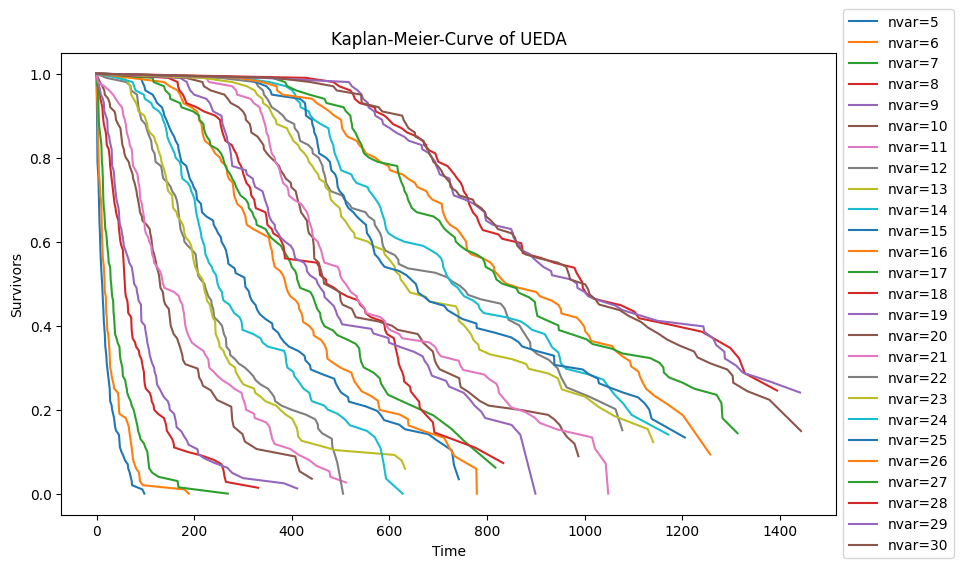

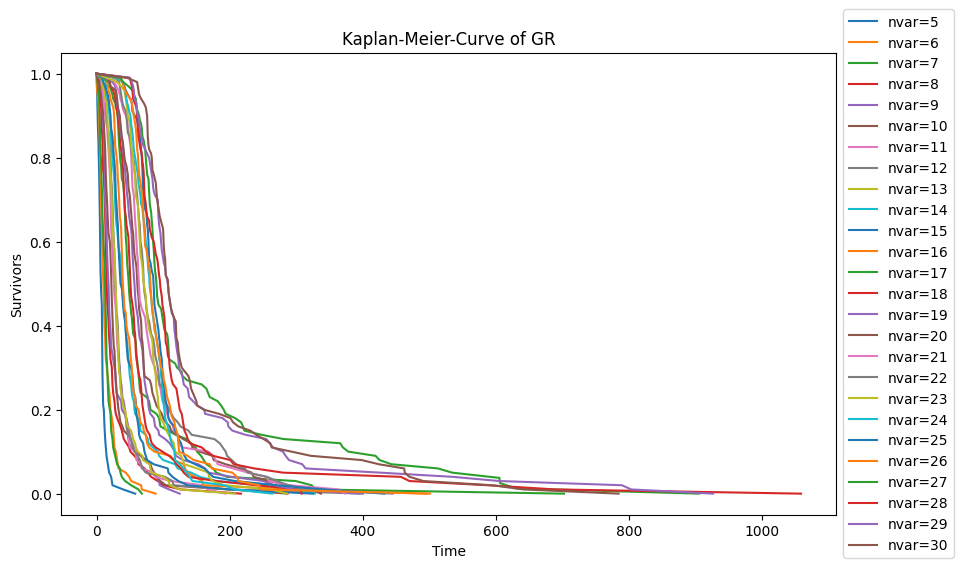

C:\Users\Biedermann\AppData\Local\Temp\ipykernel_12376\582379950.py:15: RuntimeWarning: All-NaN axis encountered
  maxRuntimeOverall = np.nanmax(list(maxTSolverPerSeedUEDA.values()))
C:\Users\Biedermann\AppData\Local\Temp\ipykernel_12376\582379950.py:15: RuntimeWarning: All-NaN axis encountered
  maxRuntimeOverall = np.nanmax(list(maxTSolverPerSeedUEDA.values()))
C:\Users\Biedermann\AppData\Local\Temp\ipykernel_12376\582379950.py:15: RuntimeWarning: All-NaN axis encountered
  maxRuntimeOverall = np.nanmax(list(maxTSolverPerSeedUEDA.values()))
C:\Users\Biedermann\AppData\Local\Temp\ipykernel_12376\582379950.py:15: RuntimeWarning: All-NaN axis encountered
  maxRuntimeOverall = np.nanmax(list(maxTSolverPerSeedUEDA.values()))
C:\Users\Biedermann\AppData\Local\Temp\ipykernel_12376\582379950.py:15: RuntimeWarning: All-NaN axis encountered
  maxRuntimeOverall = np.nanmax(list(maxTSolverPerSeedUEDA.values()))
C:\Users\Biedermann\AppData\Local\Temp\ipykernel_12376\582379950.py:15: RuntimeWarnin

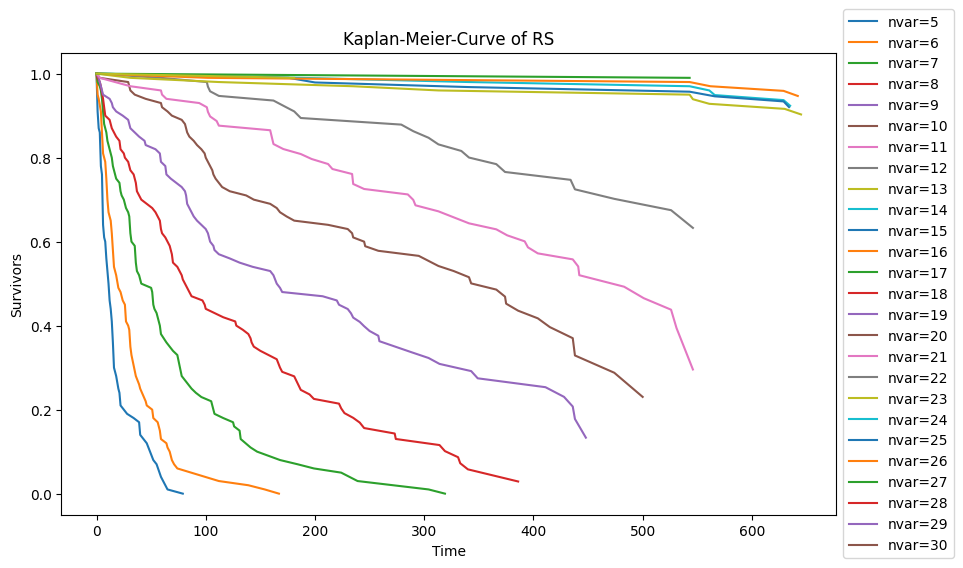

In [60]:
KaplansPlotter(nvarsUEDA, "UEDA", slots=True)
KaplansPlotter(nvarsGR, "GR", slots=True)
KaplansPlotter(nvarsRS, "RS", slots=True)

#### Topic 2: Generating predictions with the Kaplan-Meier-Curve
In this chapter, different ideas of generating predictions of the runtime with the Kaplan-Meier-Curves are investigated. The therefore investigated parameters are the Number of Variables (nvars), Runtime (tsolve) and Algorith (alg).<br>
The first approach is the moving average for time series with different intervals. It will be shown, that the hypothesis H_0 of standard distribution is refused and therefore this approach will be repudiated.<br>
Then different models will be fitted to each curve and therefore functions in order to approximate each runtime.

In [61]:
MNQDf = makeMNQDf(10, "UEDA", slots=False)
MNQDf

,m Died,q Censored,n at Risk,S(t),p(S(t)),nvar
0.0,0,0,100,1.000000,1.00,10
3.0,1,0,100,0.990000,0.99,10
7.0,1,0,99,0.989899,0.98,10
12.0,1,0,98,0.989796,0.97,10
16.0,1,0,97,0.989691,0.96,10
...,...,...,...,...,...,...
328.0,1,0,17,0.941176,0.16,10
407.0,1,0,16,0.937500,0.15,10
411.0,1,0,15,0.933333,0.14,10
416.0,1,0,14,0.928571,0.13,10


In [62]:
testDict = {
    'index': [1, 2, 3, 4, 5, 6, 7, 8],
    'p(S(t))': [22, 26, 30, 27, 24, 28, 31, 27],
}

testDf = pd.DataFrame(testDict, index=testDict["index"])
testDf = testDf.drop(columns=["index"])

testDf


,p(S(t))
1,22
2,26
3,30
4,27
5,24
6,28
7,31
8,27


In [63]:
# MNQDf = testDf

def regMovingAvg(MNQDf, windowSize):
    # make dict out of MNQDf
    sliderPointer = 0
    MNQDict = MNQDf['p(S(t))'].to_dict()
    PValDict = list(MNQDict.values())
    SAVal = dict()
    SAResult = []
    summarizer = []
    
    # even windowSize
    if windowSize % 2 == 0:
        for a in range(len(PValDict)):
            sliderPointer = a
            try:
                for i in range(windowSize+1):
                    summarizer.append(PValDict[sliderPointer])
                    sliderPointer+=1
            except IndexError:
                summarizer.append(np.nan)
                sliderPointer+=1
            val = (1/windowSize) * summarizer[0] + (1/windowSize) * summarizer[len(summarizer)-1]
            del summarizer[0]
            del summarizer[len(summarizer)-1]
            val = val + sum(summarizer)
            key = a+1           # index
            SAVal[key] = val
            summarizer.clear()
            SAVal = {key: value for key, value in SAVal.items() if not pd.isna(value)}

    else:
        for a in range(len(PValDict)):
            sliderPointer = a
            try:
                for i in range(windowSize):
                    summarizer.append(PValDict[sliderPointer])
                    sliderPointer+=1
            except IndexError:
                summarizer.append(np.nan)
                sliderPointer+=1
            val = sum(summarizer) / windowSize
            key = a+1           # index
            SAVal[key] = val
            summarizer.clear()
            SAVal = {key: value for key, value in SAVal.items() if not pd.isna(value)}

    # make the format of SAVal the same as for all other columns
    appender = int((windowSize-1)/2)
    for i in range(appender):
        SAResult.append(np.nan)
    for value in SAVal.values():
        SAResult.append(value)
    for i in range(appender):
        SAResult.append(np.nan)

    del summarizer, val, key, SAVal, sliderPointer
    return SAResult


MNQDf["Smoother"] = regMovingAvg(MNQDf, 3)
MNQDf

,m Died,q Censored,n at Risk,S(t),p(S(t)),nvar,Smoother
0.0,0,0,100,1.000000,1.00,10,NaN
3.0,1,0,100,0.990000,0.99,10,0.99
7.0,1,0,99,0.989899,0.98,10,0.98
12.0,1,0,98,0.989796,0.97,10,0.97
16.0,1,0,97,0.989691,0.96,10,0.96
...,...,...,...,...,...,...,...
328.0,1,0,17,0.941176,0.16,10,0.16
407.0,1,0,16,0.937500,0.15,10,0.15
411.0,1,0,15,0.933333,0.14,10,0.14
416.0,1,0,14,0.928571,0.13,10,0.13


In [64]:
MNQDf = MNQDf.drop(columns="Smoother")

Unfortunately, the time slots are irregular; A dependency can be seen nevertheless. For calculating such distribution, it's usually recommended to assume, that all data follows a Standard Distribution in order to calculate irregular, moving averages. In the following, a scrutiny of Standard Distribution is undergone. If applicable, the irregular average function will be shown, elsewise the model will be refused.

In [65]:
# test via Shaphiro-Wilk test for normality
dataRow = MNQDf["p(S(t))"]

stat, pVal = shapiro(dataRow)
alpha = 0.05

if pVal > alpha:
    print("The row of data likely follows a normal distribution.")
else:
    print(f"The row of data has p value of approximately {pVal}.\nIt therefore does not follow a normal distribution.")

The row of data has p value of approximately 0.003407829673960805.
It therefore does not follow a normal distribution.


The Shaphiro-Wilk test has proven, that the moving average with standard distribution will not be suitable in order to smooth the data of the timeseries.<br><br>
The new approach follows fitting different models for each of the Kapplan-Meier-Curves.<br>
The idea behind it is being displayed for UEDA, nvars=7, 13, 21 and 25, slots=True
And GR, nvars=4, 7, 13 and 21 slots= True


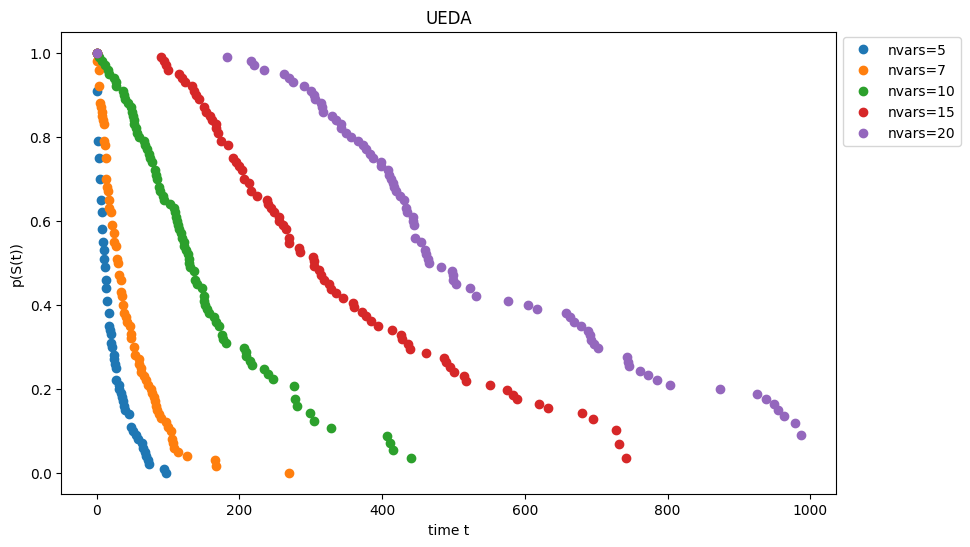

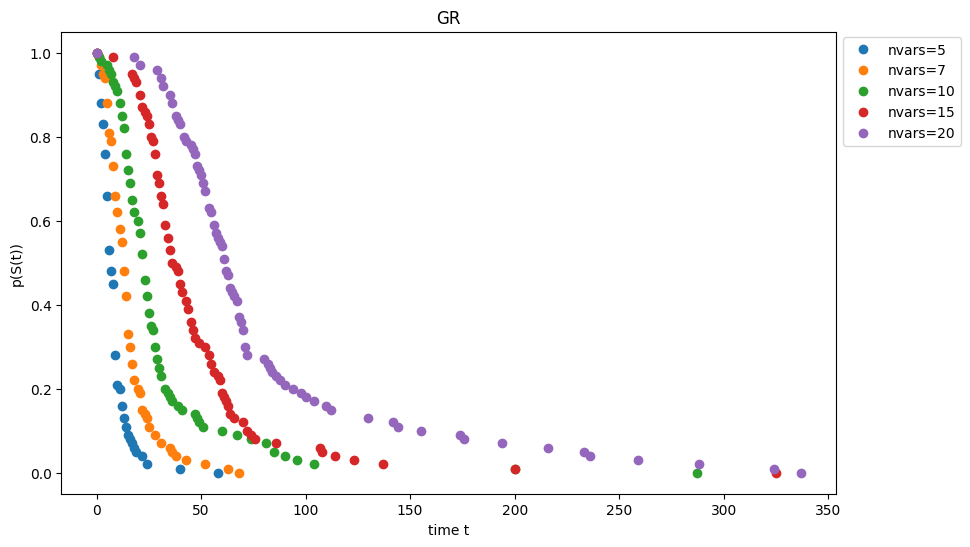

C:\Users\Biedermann\AppData\Local\Temp\ipykernel_12376\582379950.py:15: RuntimeWarning: All-NaN axis encountered
  maxRuntimeOverall = np.nanmax(list(maxTSolverPerSeedUEDA.values()))
C:\Users\Biedermann\AppData\Local\Temp\ipykernel_12376\582379950.py:15: RuntimeWarning: All-NaN axis encountered
  maxRuntimeOverall = np.nanmax(list(maxTSolverPerSeedUEDA.values()))


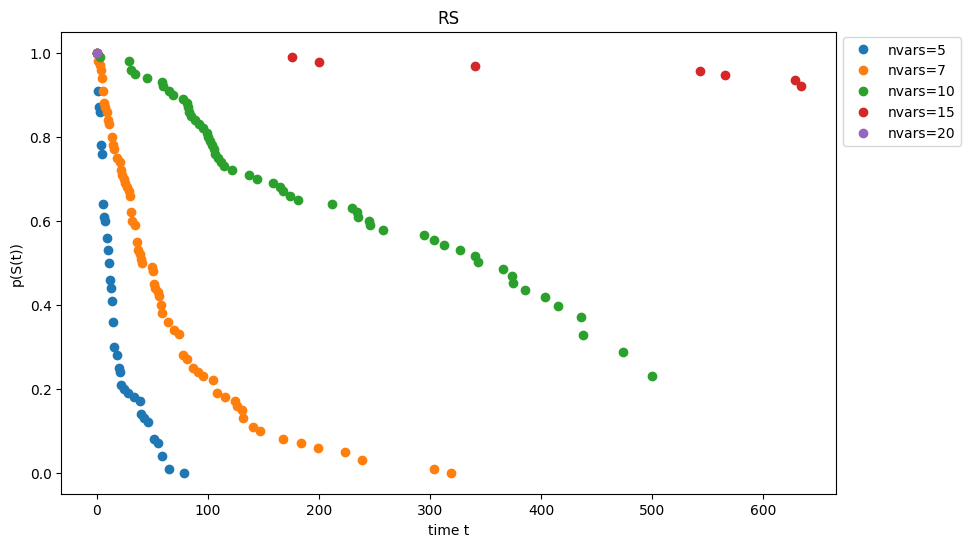

In [66]:
# Hand over array with numbers for each alg
# @Dependency: depends on MakeMNQDf
def plotMaker(arrayo, alg, slots):
    MNQDfDict = dict()
    plt.figure(figsize=(10, 6))
    for nvar in arrayo:
        MNQDf = makeMNQDf(nvar, alg, slots)
        name = f'MNQDf{nvar}{alg}'
        MNQDfDict[name]=MNQDf
        plt.plot(MNQDf.index, MNQDf["p(S(t))"], marker="o", linestyle="None", label=f'nvars={nvar}')

    plt.title(alg)
    plt.xlabel('time t')
    plt.ylabel('p(S(t))')
    plt.grid(False)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.87))
    plt.show()

    return MNQDfDict

nvars=[5, 7, 10, 15, 20]
UEDADict = plotMaker(nvars, "UEDA", True)
GRDict = plotMaker(nvars, "GR", True)
RSDict = plotMaker(nvars, "RS", True)

In [132]:
MNQDf = makeMNQDf(5, "UEDA", True)
MNQDf.head()

,m Died,q Censored,n at Risk,S(t),p(S(t)),nvar
0.0,0,0,100,1.000000,1.00,5
1.0,9,0,100,0.910000,0.91,5
2.0,12,0,91,0.868132,0.79,5
4.0,4,0,79,0.949367,0.75,5
5.0,5,0,75,0.933333,0.70,5


In [137]:
def makeSmoother(model, MNQDf):
    nvar = MNQDf["nvar"].iloc[0]
    # Prepare the data
    xOrig = MNQDf.index
    x = MNQDf.index
    yOrig = MNQDf["p(S(t))"]
    y = MNQDf["p(S(t))"]
    name = "nonImplementedModel"

    # Alter x and y in order to take appropriate formats
    match str(model):
        case "LinearRegression()":
            x = MNQDf.index.values.reshape(-1, 1)  # Reshape to a 2D array
            name = "linear"
            print("Linear Regression")
            
        case "Quadratic" | "quadratic":
            name = "quadratic"
            print("Quadratic Polynomial")
        

    print(name)
            

    # Split the data into training and testing sets
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

    # Train and make predictions
    match name:
        case "linear":
            model.fit(xTrain, yTrain)
            yPred = model.predict(xTest)

        case "Quadratic" | "quadratic":

            model = np.poly1d(np.polyfit(xTrain, yTrain, 2))
            yPred = model(xTest)
           
        case _:
            print("hoho")
  
            

    # Calculate metrics
    mae = mean_absolute_error(yTest, yPred)
    mse = mean_squared_error(yTest, yPred)

    # print("Mean Absolute Error (MAE):", mae)
    # print("Mean Squared Error (MSE):", mse)
    dataDict = {
        "model" : name,
        "mathEqu" : model,
        "xTrain" : xTrain,
        "xTest" : xTest,
        "yTrain" : yTrain,
        "yTest" : yTest,
        "yPred" : yPred,
        "x" : xOrig,
        "y" : yOrig,
        "nvar" : nvar
    }

    return dataDict


In [183]:
# For one dict only
def plotPredictions(dataDict):
    # Plot the actual vs. predicted values
    plt.scatter(dataDict["x"], dataDict["y"], label='Actual')
    plt.plot(dataDict["xTest"], dataDict["yPred"], color='red', label='Regression Line', linewidth=2)

    plt.xlabel('Time')
    plt.ylabel('p(S(t))')
    plt.title('Actual vs. Predicted p(S(t)) with Regression Line')
    plt.legend()
    plt.show()

  
# For multiple plots in one image
# @dataDictArray: holds dataDicts
# @dataDict inside Array: has to have following values: model, xTrain, xTest, yTrain, yTest, yPred
def plotPredictionsArray(dataDictArray):
    for dataDict in dataDictArray[:1]:
        modelName = str(dataDict['model'])
    
    match modelName:
        case "linear":
            for dataDict in dataDictArray:
                nvar=dataDict["nvar"]
                plt.scatter(dataDict["x"], dataDict["y"], label='Actual')
                plt.plot(dataDict["xTest"], dataDict["yPred"], color='red', label=f'Reg nvar={nvar}', linewidth=2)

            plt.axhline(y=0, color='black', linestyle='--', label='y=0')
            plt.xlabel('Time')
            plt.ylabel('p(S(t))')
            plt.title('Actual vs. Predicted p(S(t)) with Regression Line')
            plt.legend()
            plt.show()
                

        case "Quadratic" | "quadratic":
            for dataDict in dataDictArray:
                plt.scatter(dataDict["x"], dataDict["y"], label='Actual')
                x = np.linspace(min(dataDict["x"]), max(dataDict["x"]), 100)
                model = dataDict["mathEqu"]
                plt.plot(x, model(x))
            plt.legend()
            # plt.ylim(0, 100)
            plt.show()
            



#### Models for UEDA

In [184]:
dataDictArrayoLinear = []
dataDictArrayoQuadratic = []

for nvar in nvars:
    dataDictArrayoLinear.append(makeSmoother(LinearRegression(), makeMNQDf(nvar, "UEDA", True)))
for nvar in nvars:
    dataDictArrayoQuadratic.append(makeSmoother("quadratic", makeMNQDf(nvar, "UEDA", True)))

Linear Regression
linear
Linear Regression
linear
Linear Regression
linear
Linear Regression
linear
Linear Regression
linear
Quadratic Polynomial
quadratic
quaderatic
Quadratic Polynomial
quadratic
quaderatic
Quadratic Polynomial
quadratic
quaderatic
Quadratic Polynomial
quadratic
quaderatic
Quadratic Polynomial
quadratic
quaderatic


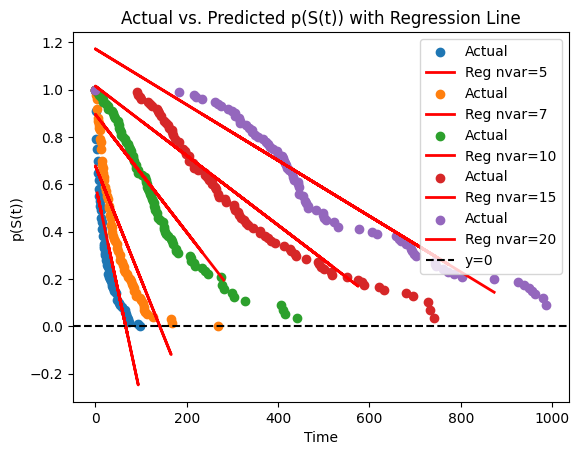

Quadratic Polynomial


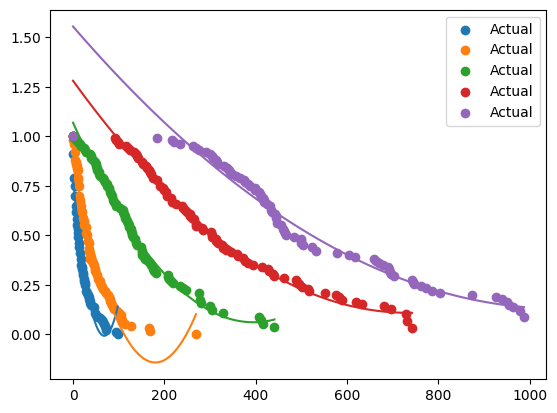

In [185]:
plotPredictionsArray(dataDictArrayoLinear)
plotPredictionsArray(dataDictArrayoQuadratic)